In [1]:
import os
from pathlib import Path

# Print the current working directory
starting_path = os.getcwd()

# Change directory to sleap-roots
if os.path.basename(os.getcwd()) == "sleap-roots":
    pass
else:
    os.chdir("..")
    
current_path = os.getcwd()

print(f"Starting directory: {starting_path}")
print(f"Current directory: {current_path}")

Starting directory: /Users/andrewoconnor/Projects/sleap-roots/notebooks
Current directory: /Users/andrewoconnor/Projects/sleap-roots


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
import seaborn as sns

# Import the sleap_roots package
import sleap_roots as sr

# Use the following notation to import individual functions from the sleap_roots package
from sleap_roots.points import get_all_pts_array
from sleap_roots.convhull import get_convhull, get_chull_area, get_chull_perimeter
from sleap_roots.lengths import get_root_lengths, get_curve_index
from sleap_roots.bases import get_bases, get_base_tip_dist
from sleap_roots.tips import get_tips
from sleap_roots.trait_pipelines import PrimaryRootPipeline

In [3]:
# Print sleap_roots version
print(sr.__version__)

0.1.3


---

The `PrimaryRootPipeline` was constructed for any plant type that has a single primary root.
This pipeline calculates the all traits related to the primary root.

The pipeline runs on the `Series` object, which should contain sleap predictions.

### Example: Dicot (`canola_7do`)

In [4]:
# Folder containing the data for a plant. It should include slp primary predictions.
canola_folder_path = "tests/data/canola_7do"

# List of slp files in the folder.
all_slps = sr.find_all_slp_paths(canola_folder_path)

print(all_slps)

['tests/data/canola_7do/919QDUH.lateral.predictions.slp', 'tests/data/canola_7do/919QDUH.primary.predictions.slp']


Series name: 919QDUH
Number of frames: 72


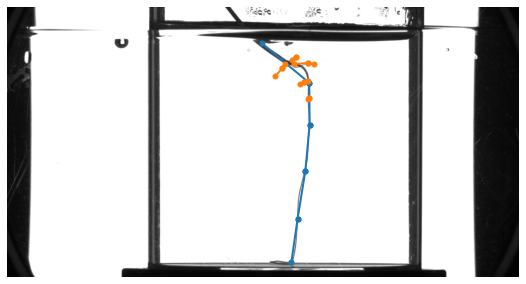

In [5]:
# Load canola predictions as a Series, using slp files.
# Since h5 files are in the folder, set the h5s parameter to True.
canola = sr.load_series_from_slps(all_slps, h5s=True)[0]

# Print the name of the series.
print(f"Series name: {canola.series_name}")

# Find the number of frames.
print(f"Number of frames: {len(canola)}")

# Plot the first frame. Note that h5 files are required to be in the folder for plotting. 
canola.plot(0, scale=0.25)

In [6]:
# Instantiate the PrimaryRootPipeline.
pipeline = PrimaryRootPipeline()

# Compute plant traits per frame.
canola_computed_traits = pipeline.compute_plant_traits(canola)
canola_computed_traits.head()

# This dataframe can be saved as a csv by changing the write_csv to True.
# Uncomment the lines below to save it in the current working directory.
# print(f"Current directory: {os.getcwd()}")
# pipeline.compute_plant_traits(canola, write_csv=True)

,plant_name,frame_idx,primary_angle_proximal,primary_angle_distal,primary_length,primary_base_pt_x,primary_base_pt_y,primary_tip_pt_x,primary_tip_pt_y,primary_base_tip_dist,curve_index,bounding_box_left_x,bounding_box_top_y,bounding_box_width,bounding_box_height
0,919QDUH,0,50.131296,7.751131,971.050417,1016.784424,144.419159,1136.096924,1020.981384,884.645018,0.088981,1016.784424,144.419159,192.108032,876.562225
1,919QDUH,1,49.428952,7.274610,967.768886,1012.655334,144.135773,1124.494019,1020.253540,883.227170,0.087357,1012.655334,144.135773,187.630798,876.117767
2,919QDUH,2,49.549504,6.979000,971.479395,1004.789490,140.731949,1112.422485,1019.996399,885.827768,0.088166,1004.789490,140.731949,187.733582,879.264450
3,919QDUH,3,46.974455,5.701038,958.449865,1004.742981,144.270248,1092.199341,1020.309387,880.393768,0.081440,1004.742981,144.270248,175.772400,876.039139
4,919QDUH,4,45.006937,4.687666,951.056866,1004.228516,148.647156,1076.076416,1024.859863,879.153473,0.075604,1004.228516,148.647156,163.986694,876.212708


For a single root, the traits can be aggregated and summarized over all frames using `compute_batch_traits`.

For each scalar csv trait over all frames, 9 summary statistics are calculated (min, max, median, mean, standard deviation, percentile 5, percentile 25, percentile 75, percentile 95).

In [7]:
canola_computed_batch_traits = pipeline.compute_batch_traits([canola])
canola_computed_batch_traits

# This dataframe can be saved as a csv by changing the write_csv to True.
# Uncomment the lines below to save it in the current working directory.
# print(f"Current directory: {os.getcwd()}")
# pipeline.compute_batch_traits([canola], write_csv=True)

Processing series: 919QDUH


,plant_name,primary_angle_proximal_min,primary_angle_proximal_max,primary_angle_proximal_mean,primary_angle_proximal_median,primary_angle_proximal_std,primary_angle_proximal_p5,primary_angle_proximal_p25,primary_angle_proximal_p75,primary_angle_proximal_p95,...,bounding_box_width_p95,bounding_box_height_min,bounding_box_height_max,bounding_box_height_mean,bounding_box_height_median,bounding_box_height_std,bounding_box_height_p5,bounding_box_height_p25,bounding_box_height_p75,bounding_box_height_p95
0,919QDUH,1.249516,62.483952,30.000497,30.319765,16.643765,3.449123,15.574207,44.797219,52.378141,...,240.503949,500.200134,891.797867,822.891092,872.78315,102.62196,542.811798,836.758713,879.508205,884.659324


---

The following section will show how each of the traits per frame are calculated.

In [8]:
# Import relevant functions.
from sleap_roots.bases import get_bases, get_base_xs, get_base_ys
from sleap_roots.tips import get_tips, get_tip_xs, get_tip_ys
from sleap_roots.angle import get_node_ind, get_root_angle
from sleap_roots.lengths import get_max_length_pts
from sleap_roots.networklength import get_bbox, get_bbox_left_x, get_bbox_top_y, get_bbox_width, get_bbox_height

In [9]:
# Obtain the primary points of a frame (frame 0).
primary_pts = canola.get_primary_points(0)

# The shape is of the form (instances, nodes, 2).
# The primary root pipeline expects instances to always be 1.
print(f"Shape of primary points: {primary_pts.shape}")
primary_pts

Shape of primary points: (1, 6, 2)


array([[[1016.78442383,  144.41915894],
        [1207.99304199,  304.11700439],
        [1208.89245605,  472.43710327],
        [1192.0501709 ,  656.82409668],
        [1160.87573242,  848.52990723],
        [1136.09692383, 1020.98138428]]])

`primary_max_length_points` are obtained to handle edge cases where the predictions on single primary root is discontinuous. In that case, the primary points array will show as a numpy array with more than 1 instance. An example of this appears at frame 67.

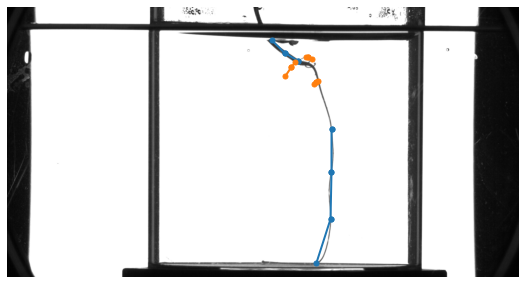

In [10]:
canola.plot(67, scale=0.25)

In [11]:
print(f"Shape of primary points at frame 67: {canola.get_primary_points(67).shape}\n")
canola.get_primary_points(67)

Shape of primary points at frame 67: (2, 6, 2)



array([[[1056.83361816,  132.4859314 ],
        [1108.94604492,  184.06916809],
        [1164.67492676,  216.75842285],
        [          nan,           nan],
        [          nan,           nan],
        [          nan,           nan]],

       [[          nan,           nan],
        [          nan,           nan],
        [1296.75146484,  488.30648804],
        [1296.68811035,  660.53668213],
        [1292.8458252 ,  848.39971924],
        [1236.2376709 , 1024.48925781]]])

The rest of this section will compute traits for frame 0, which does not have the above issue.

The PrimaryRootPipeline will reduce the dimension of `primary_points` from (1, nodes, 2) to (nodes, 2) after it becomes `primary_max_length_pts`, using the `get_max_length_pts` function.

In [12]:
# Obtain the primary_max_length_points.
primary_max_length_pts = get_max_length_pts(primary_pts)

# Expected shape: (nodes, 2).
print(f"Shape: {primary_max_length_pts.shape}")

primary_max_length_pts

Shape: (6, 2)


array([[1016.78442383,  144.41915894],
       [1207.99304199,  304.11700439],
       [1208.89245605,  472.43710327],
       [1192.0501709 ,  656.82409668],
       [1160.87573242,  848.52990723],
       [1136.09692383, 1020.98138428]])

In [13]:
# Obtain the node indices of the proximal and distal nodes.
primary_proximal_node_ind = get_node_ind(primary_max_length_pts, proximal=True)
primary_distal_node_ind = get_node_ind(primary_max_length_pts, proximal=False)

# Calculate the associated angles.
primary_angle_proximal = get_root_angle(primary_max_length_pts, primary_proximal_node_ind, proximal=True)
primary_angle_distal = get_root_angle(primary_max_length_pts, primary_distal_node_ind, proximal=False)

print(f"Primary angle proximal: {primary_angle_proximal:.2f} degrees")
print(f"Primary angle distal:   {primary_angle_distal:.2f} degrees")

Primary angle proximal: 50.13 degrees
Primary angle distal:   7.75 degrees


In [14]:
# Find the base and tip points of the root.
primary_base_pt = get_bases(primary_max_length_pts)
primary_tip_pt = get_tips(primary_max_length_pts)

print(f"Base point: {primary_base_pt}")
print(f"Tip point: {primary_tip_pt}\n")

# Extract the x,y values from each point.
primary_base_pt_x = get_base_xs(primary_base_pt)
primary_base_pt_y = get_base_ys(primary_base_pt)

primary_tip_pt_x = get_tip_xs(primary_tip_pt)
primary_tip_pt_y = get_tip_ys(primary_tip_pt)

print(f"Base x value: {primary_base_pt_x}")
print(f"Base y value: {primary_base_pt_y}\n")
print(f"Tip x value: {primary_tip_pt_x}")
print(f"Tip y value: {primary_tip_pt_y}\n")

Base point: [1016.78442383  144.41915894]
Tip point: [1136.09692383 1020.98138428]

Base x value: 1016.784423828125
Base y value: 144.41915893554688

Tip x value: 1136.096923828125
Tip y value: 1020.9813842773438



In [15]:
# Get the distance from the base to tip.
primary_base_tip_dist = get_base_tip_dist(primary_base_pt, primary_tip_pt)
print(primary_base_tip_dist)

884.6450178192455


In [16]:
# Get the length of the root.
primary_length = get_root_lengths(primary_max_length_pts)
print(primary_length)

971.0504174567843


In [17]:
# Get the curve index.
curve_index = get_curve_index(primary_length, primary_base_tip_dist)
print(curve_index)

0.08898137324716636


In [18]:
# Get the parameters of the bounding box.
bounding_box = get_bbox(primary_max_length_pts)
print(bounding_box, "\n")

# Extract parameters of the bounding box.

bounding_box_left_x = get_bbox_left_x(bounding_box)
bounding_box_top_y = get_bbox_top_y(bounding_box)
bounding_box_width = get_bbox_width(bounding_box)
bounding_box_height = get_bbox_height(bounding_box)

print(f"bounding box left x: {bounding_box_left_x}")
print(f"bounding box top y: {bounding_box_top_y}")
print(f"bounding box width: {bounding_box_width}")
print(f"bounding box height: {bounding_box_height}")

(np.float64(1016.784423828125), np.float64(144.41915893554688), np.float64(192.1080322265625), np.float64(876.5622253417969)) 

bounding box left x: 1016.784423828125
bounding box top y: 144.41915893554688
bounding box width: 192.1080322265625
bounding box height: 876.5622253417969
